# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [1]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


matplotlib settings set
matplotlib settings set


In [3]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r



def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df






srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [5]:
# Каталог ERO (9500)
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df.sample(5)

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
59,SRGe J105316.7+573551,163.319421,57.597379,149.051263,53.121417,2.276231,2174.864502,1.725409e-13,6.469277e-15,812.061157,30.447554,4299.759277,0.0,0.0,0.0,69,52,163.321430,57.596089,0.552070,122.975891,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.188862,0.007081,20.381672,163.319421,57.597379,854201065972345600,5.689724,1,0,18.651224,-1.0,0,[VV98] J105316.9+573552,1.20508,QSO,5.691327,1,1,1,1,15.423000,14.243000,11.329,30.2,26.9,7.9,1,1,1,1237658302742790373,1068523857410811904,5.741403,64196577994,0.552070,0.813768,1.228458,1.991898,137.102269,45.516323,1.327770e-13,6.910412e+19
4007,SRGe J102408.8+570607,156.036867,57.101888,153.597171,50.337347,11.004225,8.040383,8.512441e-15,3.148256e-15,15.451365,5.714559,1658.289062,0.0,0.0,0.0,6927,5816,156.038875,57.100599,4.849908,97.697998,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.009318,0.003446,8.748422,156.036867,57.101888,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,17.040001,16.353001,12.510,10.2,5.6,0.3,1,2,1,1237655108908155392,0,4.843489,66119885540,4.849908,3.934085,5.938864,9.629644,132.778974,43.047433,6.550656e-15,8.958674e+19
2851,SRGe J104524.4+590704,161.351746,59.117719,148.357638,51.333689,4.781737,59.700226,1.161651e-14,1.888342e-15,54.700184,8.891879,4301.901367,0.0,0.0,0.0,1613,1271,161.353755,59.116429,1.961326,50.090984,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012715,0.002067,17.312874,161.351746,59.117719,855363833877758336,6.141886,1,1,11.691483,NaN,0,Gaia DR2 855363838172926464,NaN,Star,5.614964,3,1,0,0,10.291000,10.314000,10.342,46.5,52.2,14.7,1,2,0,1237658304890077200,0,5.343269,58457343167,1.961326,1.709504,2.580653,4.184432,134.670049,46.229803,8.939361e-15,8.181429e+19
8025,SRGe J105157.1+563104,162.987874,56.517710,150.595560,53.714033,9.056882,9.166113,3.943009e-15,1.337841e-15,16.132257,5.473586,3737.790039,0.0,0.0,0.0,1414,1120,162.989883,56.516421,3.961921,51.494061,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.004316,0.001464,16.667049,162.987874,56.517710,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,15.872000,15.385000,12.477,22.9,12.8,0.7,1,2,0,1237657222560481768,0,8.612432,68421847925,3.961921,3.237897,4.887904,7.925552,137.709935,44.509518,3.034299e-15,6.581354e+19
5195,SRGe J104412.1+595103,161.050328,59.850804,147.654753,50.729166,6.946486,19.188122,6.586457e-15,1.619069e-15,31.482685,7.739007,4366.841309,0.0,0.0,0.0,3626,2891,161.052336,59.849515,2.988659,63.028988,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.007209,0.001772,17.462765,161.050328,59.850804,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,16.671000,16.229000,12.438,13.5,6.1,0.6,2,1,1,1237655369282945368,0,4.983668,55777964837,2.988659,2.483416,3.748945,6.078773,133.901441,46.759777,5.068535e-15,9.593587e+19


In [6]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
1743563,9011,1734,604368,158.549783,55.729465,0.212753,0.449731,0.638023,-1.135122,2.213148,-71.221320,2122.500000,485.54138,214.483550,163.042850,4.611713,1.071909,0.001206,0.000015,24.161669,23.355060,22.980886,NaN,21.636818,NaN,14.182828,4.688013,6.586424,8.146798,-2.437663,2.291340,-2.472841,8.140520,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57901.226273,57783.417662,2017-05-28 05:25:50.000,2017-01-30 10:01:26.000,9011_604368_1734
31574,9011,1979,622391,162.464615,61.780319,0.262086,0.579180,0.561593,1.048093,-0.422238,7.755578,-90.467940,491.28165,164.074040,79.476230,4.769276,1.225204,0.001634,0.000019,23.915413,23.067047,23.111950,22.446798,NaN,20.275677,NaN,5.809111,7.418797,5.006567,2.288897,-0.467371,0.313482,-0.398222,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.275356,57414.418241,2018-04-18 06:36:30.790,2016-01-27 10:02:16.000,9011_622391_1979
966695,9011,2161,609953,164.521717,57.619594,0.238014,0.560763,0.747999,1.533429,-0.376831,-80.668340,689.046140,410.35430,167.231030,83.454530,4.739799,1.160843,0.000970,0.000012,24.032590,23.110603,22.805489,22.034357,NaN,NaN,15.404306,4.821495,7.251670,6.833225,3.338441,-0.406006,-2.512152,2.369090,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.408691,57784.446158,2018-03-17 09:48:30.941,2017-01-31 10:42:28.080,9011_609953_2161
1610929,9011,1477,606794,161.703707,56.522411,0.743781,0.489249,0.144916,-0.565251,0.763478,-45.491974,-51.324368,87.48230,26.773624,3.963459,3.282748,0.807431,0.001073,0.000015,22.805649,23.265574,24.591278,NaN,22.792456,NaN,NaN,6.956735,2.531534,0.288505,-1.024141,0.686039,-1.490129,-0.201475,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.405780,57784.433639,2018-03-17 09:44:19.410,2017-01-31 10:24:26.379,9011_606794_1477
2034306,9011,1665,610709,155.526869,57.775643,0.173093,0.354449,0.335770,0.370556,-1.110846,19.064070,74.529130,577.84410,241.606200,93.239970,4.636022,1.140113,0.001366,0.000017,24.363130,23.598383,23.669382,23.575508,NaN,19.299152,17.819069,4.160880,5.509444,3.242224,0.797860,-1.186117,0.704521,0.304319,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.386955,57842.273037,2018-03-17 09:17:12.879,2017-03-30 06:33:10.361,9011_610709_1665


# CSC

In [23]:
len(csc_init_df)
#267265

317167

In [7]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_init_df = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)

# CSC catalogue filtering
csc_df = csc_init_df[(csc_init_df['conf_flag'] == False) &
                              (csc_init_df['extent_flag'] == False) &
                              (csc_init_df['sat_src_flag'] == False) &
                              (csc_init_df['streak_src_flag'] == False) &
                              (csc_init_df['pileup_flag'] == False) &
                              (csc_init_df['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df = csc_df.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_df.flux_aper_hilim_s - csc_df.flux_aper_s
s_down = csc_df.flux_aper_s - csc_df.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_df.flux_aper_hilim_m - csc_df.flux_aper_m
m_down = csc_df.flux_aper_m - csc_df.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)

sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_df['flux_aper_sm_err'] = sm_err


print(f'CSC Sources: {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources: 267265


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,flux_csc_05_2,radec_err_csc,r_98_csc,flux_05_2,flux_aper_sm_err
134932,2CXO J111739.7-041929,169.415424,-4.324959,7.181156,4.335546,41.069899,2.410256,10.890359,MARGINAL,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,1.931832e-15,1.176363e-15,1.120346e-16,2.184675e-15,1.176363e-15,3.427006,9.585847,1.176363e-15,2.425172e-15
308874,2CXO J230133.8+160150,345.391012,16.030777,5.897331,4.557962,134.133265,2.702703,12.672955,MARGINAL,False,False,False,False,False,False,False,6.372255e-16,1.784231e-16,1.096028e-15,4.945531e-16,1.075115e-16,8.815947e-16,1.131779e-15,3.045014,8.517361,1.131779e-15,8.488825e-16
1183,2CXO J000908.5+192143,2.285697,19.361988,1.225348,1.225340,0.000000,3.875000,25.061346,TRUE,False,False,False,False,False,False,False,2.229723e-15,1.142053e-15,3.317393e-15,2.770154e-15,1.418860e-15,4.053884e-15,4.999877e-15,0.707956,1.980260,4.999877e-15,2.416612e-15
80810,2CXO J072015.1+181615,110.063330,18.270864,16.538975,12.512359,167.829500,2.883721,16.879501,MARGINAL,False,False,False,False,False,False,False,7.377714e-15,4.426628e-15,1.032880e-14,3.898139e-15,1.146511e-15,6.649766e-15,1.127585e-14,8.472598,23.699126,1.127585e-14,5.706200e-15
196639,2CXO J144654.4+092417,221.726752,9.404768,1.478143,1.038995,134.493958,3.636364,29.346586,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,2.045762e-16,1.363571e-16,1.239610e-17,2.541201e-16,1.363571e-16,0.738136,2.064677,1.363571e-16,2.666193e-16


In [8]:
csc_df.to_pickle(data_path+'csc_cleared.pkl')

## CSC x ERO cross-match

In [9]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 566


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches
61,SRGe J105332.0+572456,163.383205,57.415542,149.234377,53.270430,3.338336,233.746094,3.861285e-14,3.395691e-15,183.257309,16.116013,4335.876465,0.0,0.0,0.0,131,107,163.385214,57.414252,1.224421,53.071556,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.042265,0.003717,19.983629,163.383205,57.415542,854186467379449600,6.443190,1,0,20.671984,-1.0,0,[VV98] J105331.8+572454,1.95800,QSO,6.432975,1,1,1,0,16.497999,16.040001,12.710,15.5,8.0,2.3,2,1,1,1237655107299246154,7987372644902391808,6.411906,64899364828,1.224421,1.193478,1.801665,2.921332,137.284082,45.382271,2.971410e-14,7.149761e+19,2CXO J105331.6+572453,163.382075,57.414967,0.819087,0.765503,47.920284,20.659257,1183.681404,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.458019,1.281148,NaN,NaN,3.013799,1,1
191,SRGe J104900.5+590931,162.251901,59.158687,147.808213,51.646514,5.379010,71.396576,1.465162e-14,2.214822e-15,69.060631,10.439599,4306.183594,0.0,0.0,0.0,1487,1180,162.253910,59.157398,2.249967,48.539898,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.016038,0.002424,18.604115,162.251901,59.158687,-1,-1.000000,0,-1,NaN,-1.0,-1,CXOSW J104900.3+590930,NaN,X,6.258198,1,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,1237658304890274025,0,4.908560,58305627457,2.249967,1.923033,2.902995,4.707097,135.197476,46.516974,1.127499e-14,8.151394e+19,2CXO J104900.9+590929,162.253811,59.158252,8.909019,5.091548,87.509156,7.074130,60.787433,TRUE,False,False,False,False,False,False,False,8.662058e-15,6.025779e-15,1.117280e-14,7.384930e-15,5.839247e-15,8.844741e-15,1.604699e-14,4.192145,11.726057,1.604699e-14,4.215919e-15,3.857110,1,1
66,SRGe J104510.4+555615,161.293258,55.937399,152.363376,53.366849,3.562326,258.646515,3.575410e-14,3.165048e-15,168.197617,14.889298,4297.752930,0.0,0.0,0.0,586,486,161.295266,55.936109,1.344917,93.893974,0.000004,6.268413e+08,6.270701e+08,0.0,0.0,0.039136,0.003464,20.536791,161.293258,55.937399,850985200619012992,8.166363,1,0,20.002674,-1.0,0,SDSS J104510.31+555616.8,0.72864,QSO,8.168193,1,1,0,1,15.440000,14.400000,10.968,28.2,24.3,8.3,1,2,0,1237657771786895696,0,5.515613,70742867566,1.344917,1.273556,1.922550,3.117342,137.021119,43.520218,2.751417e-14,5.572114e+19,2CXO J104510.3+555616,161.293061,55.938001,0.715084,0.712397,114.064836,14.495777,1436.724307,TRUE,False,False,False,False,False,False,False,2.821377e-14,2.487889e-14,3.154866e-14,NaN,NaN,NaN,NaN,0.412372,1.153467,NaN,NaN,2.204149,1,1
481,SRGe J104813.9+571309,162.057849,57.219260,150.273550,52.869353,8.773280,18.089481,5.960115e-15,1.553419e-15,27.211937,7.092406,4171.116699,0.0,0.0,0.0,7780,6644,162.059858,57.217970,3.831968,144.076462,0.000009,6.268413e+08,6.270701e+08,0.0,0.0,0.006524,0.001700,17.544849,162.057849,57.219260,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,0,17.306000,16.858000,12.669,9.6,3.7,0.3,1,1,0,1237655107298919157,0,2.264384,65662495149,3.831968,3.136507,4.734847,7.677375,136.579100,44.831698,4.586541e-15,7.002923e+19,2CXO J104814.1+571309,162.05894

## CSC x DESI cross-match

In [10]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2543 out of 566 x 2418574
	 total unique pairs: 2543
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544

In [11]:
csc_desi = csc_desi_all.query("desi_sep<=1.1*csc_r_98_csc") #of you want only sep < r_false and the only one, replace 1.1*csc_r_98_csc with @r_false
#desi within 1.1*csc_r_98_csc and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]


#csc_desi = csc_desi_all.query("desi_sep<=@r_false")
csc_desi = csc_desi.query("desi_sep<=@r_false")

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 372


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
2274,SRGe J104722.9+585033,161.845225,58.842524,148.412011,51.706862,10.014643,7.975955,4.093821e-15,1.396039e-15,19.089035,6.509577,4259.931641,0.0,0.0,0.0,8904,7750,161.847234,58.841235,4.399482,90.190491,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.004481,0.001528,19.789173,161.845225,58.842524,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 588,0.680000,Galaxy,8.042606,3,1,0,0,16.320999,16.488001,12.455,16.5,5.2,0.7,1,1,0,1237655109446598967,0,7.787251,59477280415,4.399482,3.580303,5.404797,8.763675,135.194666,46.137733,3.150355e-15,8.375269e+19,2CXO J104722.5+585033,161.843914,58.842556,0.885940,0.814588,99.070735,9.369712,280.821016,TRUE,False,False,False,False,False,False,False,5.103785e-15,4.083028e-15,6.067833e-15,3.489494e-15,2.877300e-15,4.101687e-15,8.593278e-15,0.491682,1.375308,8.593278e-15,1.649514e-15,2.444302,1,1,9011,716,613769,161.843846,58.842553,1.215065,3.113447,8.691670,23.828382,13.247064,-10.99621,690.98535,344.05005,90.44775,36.432106,3.500938,1.029486,0.001159,0.000015,22.255962,21.244978,20.139982,19.055400,19.693558,NaN,15.401236,22.537733,29.610134,52.462067,44.584793,13.440945,-0.374302,2.636906,REX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.402846,57851.323866,2018-03-17 09:40:05.868,2017-04-08 07:46:22,9011_613769_716,0.126546,5,1,2.727718
2102,SRGe J105534.8+574116,163.895196,57.687877,148.587811,53.282923,9.265594,10.701097,4.598781e-15,1.392832e-15,21.180170,6.414834,4207.597656,0.0,0.0,0.0,6550,5462,163.897205,57.686587,4.057436,94.213852,0.000010,6.268413e+08,6.270701e+08,0.0,0.0,0.005034,0.001525,16.934362,163.895196,57.687877,860195023547028224,8.616540,1,1,16.922781,NaN,0,NaN,NaN,NaN,-1.000000,0,1,0,0,15.266000,15.381000,12.463,31.2,13.2,1.2,1,1,1,1237658302742921272,0,8.177193,63848049885,4.057436,3.312513,5.000544,8.108192,137.400926,45.760340,3.538941e-15,6.478217e+19,2CXO J105535.0+574115,163.896062,57.687523,1.323599,0.972411,63.295565,2.054054,82.597562,TRUE,False,False,False,False,False,False,False,0.000000e+00,0.000000e+00,9.187015e-15,0.000000e+00,0.000000e+00,4.414282e-15,0.000000e+00,0.670987,1.876851,0.000000e+00,1.019250e-14,2.096567,1,1,9011,1391,610727,163.896052,57.687436,0.318310,0.528948,1.265430,2.517339,4.228693,16.49705,-129.70448,534.61450,194.14099,141.205750,4.6

In [12]:
len(csc_desi.query("~csc_flux_05_2.isna() & csc_flux_05_2!=0"))

287

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [13]:
ero_xmm_all = pd.read_csv(data_path+'xmm_allsky_full_ero_slim_point_30sec.csv')
ero_xmm_all = only_reliable_xmm(ero_xmm_all) #ALWAYS CHECK IF XMM IS RELIABLE

print(f'Reliable XMM Sources within 30 arcsec from eROSITA: {ero_xmm_all.shape[0]}')

# Поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2 = lambda x: x.SC_EP_2_FLUX + x.SC_EP_3_FLUX)
# Ошибки на поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.SC_EP_2_FLUX_ERR ** 2 + x.SC_EP_3_FLUX_ERR ** 2))

xmm_err = ero_xmm_all['SC_POSERR']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
ero_xmm_all.insert(11, 'sigma', xmm_sigma)
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
ero_xmm_all.insert(11, 'xmm_pos_r98', xmm_r98)


ero_xmm_all['xmm_ero_flux_ratio'] = ero_xmm_all['flux_05_2']\
                                                / ero_xmm_all['flux_05-20']

ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')


ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')



ero_xmm_all.sample(10)

Reliable XMM Sources within 30 arcsec from eROSITA: 844
XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
501,SRGe J103233.4+574355,158.139085,57.731908,7.285684e-15,2.452257,6.859330,33.794980,0.0,7.545263,203032602010024,4XMM J103233.6+574354,1.120902,0.400730,158.140144,57.731758,0.565087,261.9020,2.707090e-15,3.325700e-16,4.084160e-15,3.951770e-16,3.441690e-15,4.146130e-16,5.180310e-15,9.065810e-16,4.303070e-15,3.654940e-15,2.151830e-14,3.891860e-15,1.375610e-14,9.574360e-16,0.185317,0.073842,-0.158368,0.073249,-0.294619,0.093186,-0.688371,0.207931,0.0,NaN,-1.478330,0.146056,0.401004,0.267952,False,1,1.968810e-14,4.979400e-15,2.439170e-14,6.239060e-15,53467.914178,53510.606285,2,False,http://xmm-catalog.irap.omp.eu/source/20303260...,NaN,1.0,2.105194,7.525850e-15,5.727729e-16,1.032964
806,SRGe J104701.2+590649,161.754991,59.113673,3.862061e-15,2.977676,8.329005,12.923547,0.0,9.161905,205541201010079,4XMM J104701.4+590648,3.631065,1.298130,161.755995,59.113374,1.830550,11.5322,7.056480e-16,1.113250e-15,2.827560e-15,1.644690e-15,4.920260e-15,2.040040e-15,1.035520e-14,4.956370e-15,0.000000e+00,1.407260e-14,1.880860e-14,1.518910e-14,1.601990e-14,4.437420e-15,0.638525,0.497948,0.333689,0.317388,-0.119889,0.312073,-1.000000,0.569459,0.0,NaN,-0.875600,NaN,NaN,NaN,NaN,0,1.880860e-14,1.518910e-14,1.880860e-14,1.518910e-14,54750.880949,54751.340602,1,False,http://xmm-catalog.irap.omp.eu/source/20554120...,NaN,1.0,2.144450,7.747820e-15,2.620452e-15,2.006136
852,SRGe J104511.5+591039,161.297888,59.177546,3.413805e-15,3.049342,8.529466,10.927908,0.0,9.382413,205541201010098,4XMM J104511.4+591037,2.633179,0.941379,161.297851,59.177124,1.327480,13.4789,1.751840e-16,1.532800e-16,1.081370e-15,3.293290e-16,1.443930e-15,4.541620e-16,6.830060e-16,6.294200e-16,7.713030e-16,4.089110e-15,7.481600e-15,4.459750e-15,5.035670e-15,9.776860e-16,0.341827,0.180612,0.028521,0.184277,-0.491999,0.177897,0.685525,0.213481,0.0,NaN,-0.519247,NaN,NaN,NaN,NaN,0,6.359740e-15,4.761290e-15,1.550620e-14,1.273410e-14,54750.880949,54781.372685,2,False,http://xmm-catalog.irap.omp.eu/source/20554120...,NaN,1.0,1.521741,2.525300e-15,5.609997e-16,0.739732
115,SRGe J103630.6+575722,159.127322,57.956213,2.434985e-14,1.261332,3.528135,239.620880,0.0,5.000000,205562110010023,4XMM J103630.4+575723,3.559616,1.272587,159.127042,57.956471,1.794530,25.5588,1.635780e-15,8.021220e-16,3.919580e-15,1.204840e-15,4.552410e-15,1.494750e-15,4.225030e-15,2.815970e-15,6.805220e-15,1.392800e-14,2.470470e-14,1.460290e-14,1.510480e-14,3.157530e-15,0.521886,0.203145,-0.049182,0.206634,-0.443383,0.268510,-0.116717,0.609577,0.0,NaN,0.975811,NaN,NaN,NaN,NaN,0,2.470470e-14,1.460290e-14,2.470470e-14,1.460290e-14,54790.704919,54790.786331,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,1.073573,8.471990e-15,1.919874e-15,0.347928
700,SRGe J103357.6+580813,158.489951,58.136836,4.803080e-15,2.624180,7.340224,17.649162,0.0,8.074247,205016215010023,4XMM J103358.0+580809,3.815102,1.363925,158.491902,58.135915,1.923330,12.8293,3.212270e-15,1.398420e-15,3.481470e-15,1.480020e-15,1.166910e-15,1.162900e-15,5.284690e-16,1.762670e-15,1.638030e-14,2.159700e-14,2.641580e-14,2.189180e-14,7.454100e-15,3.010150e-15,0.034761,0.279017,-0.215069,0.349923,-0.826603,0.349206,0.748283,0.444411,0.0,NaN,-0.646291,NaN,NaN,NaN,NaN,0,2.641580e-14,2.189180e-14,2.641580e-14,2.189180e-14,54244.090359,54244.241262,1,Fal

In [14]:
xmm_desi = cross_match_data_frames(ero_xmm_all, desi, colname_ra1 = 'SC_RA',colname_dec1 = 'SC_DEC' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')

#same as Chandra
xmm_desi = xmm_desi.query("desi_sep<=1.1*xmm_pos_r98") 

group = xmm_desi.groupby('SRCID')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['SRCID'].isin(single_idxes)]


xmm_desi = xmm_desi.query("desi_sep<=@r_false")
print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

assert xmm_desi.desi_desi_id.nunique() == xmm_desi.shape[0]
xmm_desi


cross-match radius 15 arcsec
total matches: 3284 out of 740 x 2418574
	 total unique pairs: 3284
	 total non-unique pairs (duplicates in df2): 0
cross-matches: only one desi within r_false and it is unique 417


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,4XMM J104117.9+584929,1.622515,0.580060,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,0.012697,1.426367,False,0,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,54595.266366,54595.352928,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.015272,8.770400e-14,6.519681e-15,0.482614,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.00964,212.870970,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31.000,9011_613766_43,0.975167,9,1
27,SRGe J104144.5+594258,160.435424,59.716091,1.125101e-13,0.835654,2.337449,1862.223500,0.0,5.000000,205562117010001,4XMM J104144.4+594257,1.179152,0.421555,160.435401,59.715994,0.594453,2003.7300,5.876380e-14,4.136030e-15,7.387460e-14,4.907840e-15,5.858620e-14,4.984410e-15,3.500830e-14,6.824610e-15,6.038710e-14,2.863610e-14,2.918500e-13,3.073900e-14,2.126020e-13,1.089320e-14,0.044237,0.048125,-0.225406,0.051041,-0.652086,0.060034,-0.355709,0.212099,0.0,NaN,-2.710570,0.446004,0.015899,0.549870,False,0,2.918500e-13,3.073900e-14,2.918500e-13,3.073900e-14,54803.047488,54803.128889,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.351432,1.324608e-13,6.995087e-15,1.177323,9011,1391,616727,160.435399,59.715943,5.154994,12.449943,23.723682,42.546776,30.527184,-13.516494,-1596.612000,317.36188,101.523450,41.334335,2.876914,0.874156,0.001166,0.000014,20.679901,19.735455,19.047152,18.425570,18.786894,NaN,NaN,91.834440,125.444180,152.523790,72.165580,28.541790,-0.461621,-6.047804,SER,-0.350328,0.505335,1.484016,0.191159,-2.702236,0.241721,G2,855637337395590272,58194.413159,57846.199361,2018-03-17 09:54:56.929,2017-04-03 04:47:04.770,9011_616727_1391,0.180411,6,1
30,SRGe J104604.2+573819,161.517497,57.638481,8.902620e-14,0.902229,2.523671,1257.858500,0.0,5.000000,205562116010002,4XMM J104604.1+573818,1.123923,0.401810,161.517218,57.638544,0.566610,1036.3000,3.338960e-14,3.329060e-15,5.360760e-14,4.436150e-15,

# Joining CSC and XMM counterparts

In [15]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'DET_LIKE_0', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'Separation','SRCID', 'SC_RA','SC_DEC', 'xmm_pos_r98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [16]:
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 417
CSC companions 372
Total companions possible 789


In [17]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [18]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0', 'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'flux_05-20', 'DET_LIKE_0','desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('After Flux filter')
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

After Flux filter
XMM companions 408
CSC companions 273
Total companions possible 681


In [19]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')

final_ctps_cut = final_ctps


# #save final_ctps_csv to csv
final_ctps_csv = final_ctps_cut[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'srcname_fin':'ID'}, inplace=True)
final_ctps_csv.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
final_ctps_csv.ID = final_ctps_csv.ID.str.encode('utf-8')
final_ctps_csv.desi_id_true_ctp = final_ctps_csv.desi_id_true_ctp.str.encode('utf-8')
final_ctps_csv.to_pickle(data_path+'validation_ctps_ero_desi_lh_no_hostless.pkl')

final_ctps_cut

,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,flux_05-20,DET_LIKE_0,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103105.9+573747,157.774385,57.629820,2.927322,3.362480e-15,10.766065,9011_610714_1440,157.774282,57.630173,csc,1,1,1.288998
1,SRGe J103123.8+574309,157.849052,57.719110,1.194977,2.582066e-14,241.302124,9011_610714_2092,157.848257,57.719498,csc,1,1,2.070640
2,SRGe J103130.8+573932,157.878489,57.658958,3.460543,4.648196e-15,16.483074,9011_610714_2412,157.880032,57.659682,csc,1,1,3.952662
3,SRGe J103137.0+573159,157.904134,57.532955,2.291806,7.812335e-15,37.274281,9011_609939_1093,157.904358,57.533253,csc,1,1,1.154828
4,SRGe J103143.5+573156,157.931232,57.532161,2.144571,1.160345e-14,61.354324,9011_609939_1343,157.930621,57.532696,csc,1,1,2.261288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,SRGe J110614.9+585347,166.562283,58.896277,2.956780,6.742923e-15,11.506282,9011_614527_601,166.560542,58.897072,csc,1,1,4.321613
677,SRGe J110633.0+590313,166.637537,59.053617,7.192980,1.009282e-14,8.283731,9011_614527_1198,166.637299,59.052750,csc,1,1,3.150115
678,SRGe J110645.0+590331,166.687525,59.058674,5.037064,7.184641e-15,6.913430,9011_614527_1596,166.687325,59.058440,csc,1,1,0.920125
679,SRGe J110648.4+585514,166.701535,58.920668,3.815435,7.916981e-15,8.045092,9011_614527_1704,166.701968,58.921308,csc,1,1,2.442214


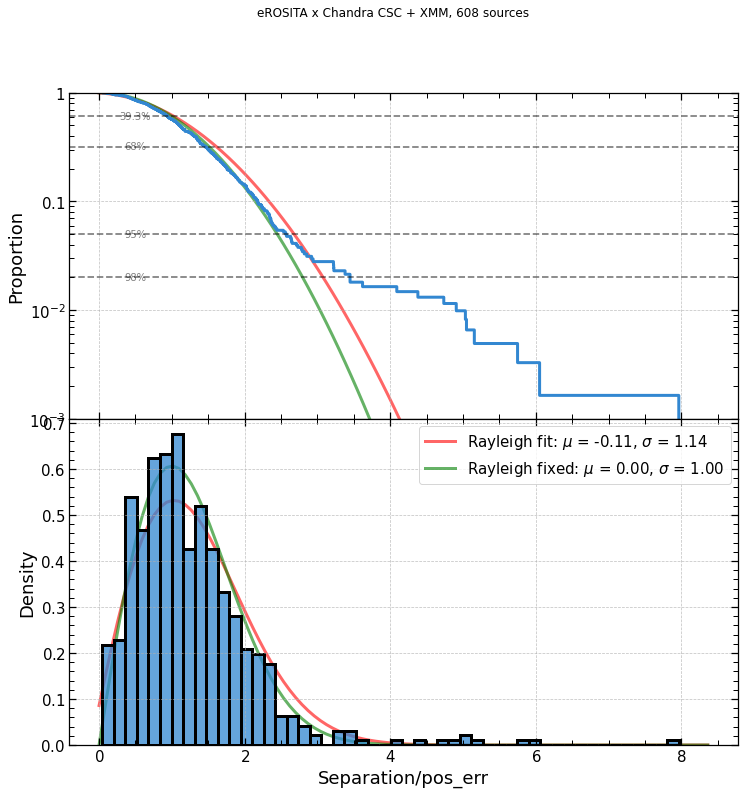

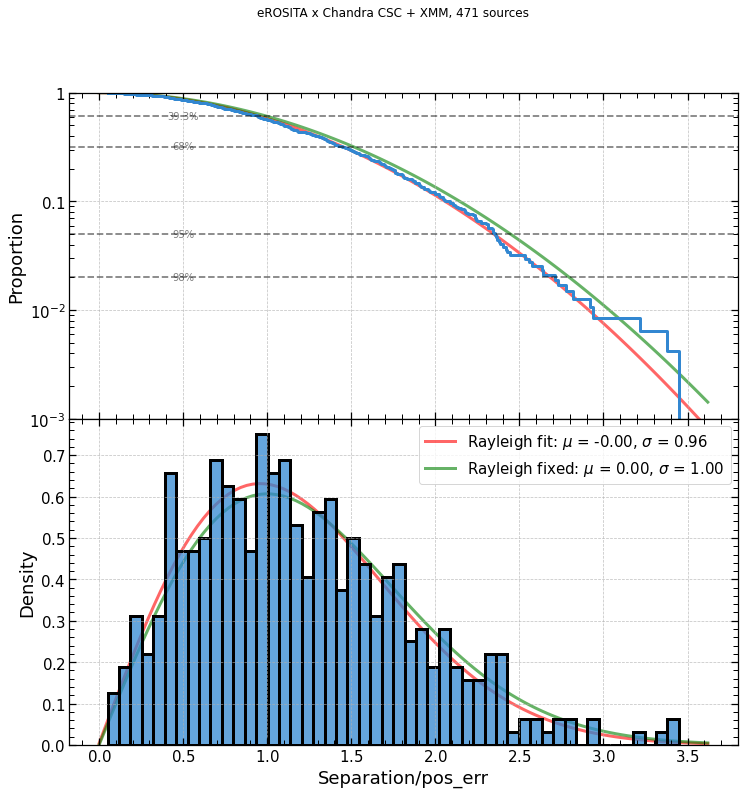

In [21]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps.query('DET_LIKE_0>15'), sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')

